<a href="https://colab.research.google.com/github/churamani2030dev/IBM_watson_studio_datascience/blob/main/IBM_watson_studio_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Analyze user-item interaction data from "user-item-interactions.csv" and article data from "articles_community.csv" to build and compare recommendation systems, including rank-based, user-user collaborative filtering, content-based, and matrix factorization methods, evaluating their performance and discussing trade-offs.

## Quick eda on the interactions table

### Subtask:
Load the `user-item-interactions.csv` dataset and perform exploratory data analysis to compute key statistics, including the number of unique users and articles, interaction totals per user and article, and summary statistics for interaction counts. Verify the results with provided tests.


**Reasoning**:
Load the `user-item-interactions.csv` dataset into a pandas DataFrame and perform exploratory data analysis to compute key statistics as per the instructions.



In [1]:
import pandas as pd

# Load the dataset
df_interactions = pd.read_csv('/content/user-item-interactions.csv')

# 2. Determine the number of unique users
unique_users = df_interactions['email'].nunique()

# 3. Determine the number of unique articles
unique_articles = df_interactions['article_id'].nunique()

# 4. Calculate the total number of interactions
total_interactions = df_interactions.shape[0]

# 5. Calculate the total number of interactions for each user
user_interactions = df_interactions['email'].value_counts()

# 6. Calculate the total number of interactions for each article
article_interactions = df_interactions['article_id'].value_counts()

# 7. Compute descriptive statistics for user interaction counts
user_interaction_stats = user_interactions.describe()

# 8. Compute descriptive statistics for article interaction counts
article_interaction_stats = article_interactions.describe()

# Display the results
print(f"Number of unique users: {unique_users}")
print(f"Number of unique articles: {unique_articles}")
print(f"Total number of interactions: {total_interactions}")
print("\nUser Interaction Counts Statistics:")
display(user_interaction_stats)
print("\nArticle Interaction Counts Statistics:")
display(article_interaction_stats)

Number of unique users: 5148
Number of unique articles: 714
Total number of interactions: 45993

User Interaction Counts Statistics:


,count
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000



Article Interaction Counts Statistics:


,count
count,714.000000
mean,64.415966
std,109.175923
min,1.000000
25%,8.000000
50%,25.000000
75%,69.000000
max,937.000000


## Implement a rank-based baseline

### Subtask:
Sort articles by their total interaction counts and create helper functions to return the top k article IDs and names. This will serve as a cold-start fallback and a benchmark for other methods.


**Reasoning**:
Sort the article_interactions Series in descending order and create the helper functions as requested in the instructions.



In [2]:
# 1. Sort the article_interactions Series in descending order.
sorted_article_interactions = article_interactions.sort_values(ascending=False)

# 2. Create a function called get_top_article_ids
def get_top_article_ids(k):
  """
  Returns a list of the top k article IDs based on sorted interaction counts.

  Args:
    k: The number of top article IDs to return.

  Returns:
    A list of the top k article IDs.
  """
  return sorted_article_interactions.head(k).index.tolist()

# 3. Create a function called get_article_names
def get_article_names(article_ids):
  """
  Returns a list of unique article names for a given list of article IDs.

  Args:
    article_ids: A list of article IDs.

  Returns:
    A list of unique article names.
  """
  article_names = df_interactions[df_interactions['article_id'].isin(article_ids)]['title'].unique().tolist()
  return article_names

# 4. Create a function called get_top_articles
def get_top_articles(k):
  """
  Returns a list of the top k article names based on sorted interaction counts.

  Args:
    k: The number of top article names to return.

  Returns:
    A list of the top k article names.
  """
  top_article_ids = get_top_article_ids(k)
  top_article_names = get_article_names(top_article_ids)
  return top_article_names

## Build user–user collaborative filtering

### Subtask:
Create a binary user-item matrix. Implement a similarity metric (cosine or Jaccard) to find nearest neighbors for a given user. Develop a recommendation function that aggregates recommendations from neighbors' unseen articles, with a tie-breaking mechanism based on global popularity. Include a variant that prioritizes users with many common interactions and then by article popularity. Create a function to provide recommendations for new users (e.g., by falling back to the rank-based method).


**Reasoning**:
Create the user-item matrix, define a function to find nearest neighbors using cosine similarity, and implement a recommendation function that aggregates recommendations from neighbors and uses global popularity for tie-breaking.



**Reasoning**:
The error indicates duplicate entries in the index when creating the user-item matrix. This is likely due to multiple interactions between the same user and article. To fix this, we need to ensure that for each user-article pair, there is only one entry in the intermediate structure before unstacking. We can achieve this by dropping duplicates before applying the aggregation.



In [4]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Create a binary user-item matrix - Fix: Drop duplicates before unstacking
user_item_matrix = df_interactions.drop_duplicates(['email', 'article_id']).groupby('email')['article_id'].apply(lambda x: pd.Series(1, index=x)).unstack(fill_value=0)

# 2. Define a function to find nearest neighbors
def find_nearest_neighbors(user_id, user_item_matrix, n=10):
  """
  Finds the n nearest neighbors for a given user based on cosine similarity.

  Args:
    user_id: The email address of the user.
    user_item_matrix: The binary user-item matrix.
    n: The number of nearest neighbors to return.

  Returns:
    A list of the top n nearest neighbor user IDs (excluding the user itself).
  """
  if user_id not in user_item_matrix.index:
    return []

  user_vector = user_item_matrix.loc[user_id].values.reshape(1, -1)
  similarities = cosine_similarity(user_vector, user_item_matrix)[0]

  # Get the indices of the top n+1 similar users (including the user itself)
  most_similar_users_indices = np.argsort(similarities)[::-1][:n+1]

  # Get the user IDs of the top n+1 similar users
  most_similar_user_ids = user_item_matrix.index[most_similar_users_indices].tolist()

  # Remove the user itself from the list
  if user_id in most_similar_user_ids:
    most_similar_user_ids.remove(user_id)

  # Return the top n nearest neighbors
  return most_similar_user_ids[:n]

# 3. Define a function for recommendations based on nearest neighbors with popularity tie-breaking
def recommend_articles_neighbor_popularity(user_id, k, user_item_matrix, nearest_neighbors_func):
  """
  Recommends articles based on nearest neighbors' interactions, using popularity for tie-breaking.

  Args:
    user_id: The email address of the user.
    k: The number of recommendations to return.
    user_item_matrix: The binary user-item matrix.
    nearest_neighbors_func: The function to find nearest neighbors.

  Returns:
    A list of recommended article IDs.
  """
  if user_id not in user_item_matrix.index:
    return get_top_article_ids(k) # Fallback for new users

  nearest_neighbors = nearest_neighbors_func(user_id, user_item_matrix)

  if not nearest_neighbors:
    return get_top_article_ids(k) # Fallback if no neighbors found

  # Get articles the user has already interacted with
  interacted_articles = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 1].index.tolist()

  # Aggregate recommendations from neighbors
  neighbor_recommendations = {}
  for neighbor_id in nearest_neighbors:
    neighbor_interactions = user_item_matrix.loc[neighbor_id][user_item_matrix.loc[neighbor_id] == 1].index.tolist()
    for article_id in neighbor_interactions:
      if article_id not in interacted_articles:
        neighbor_recommendations[article_id] = neighbor_recommendations.get(article_id, 0) + 1

  # Sort recommendations by count and then by global popularity (higher count first, then higher global popularity)
  sorted_recommendations = sorted(neighbor_recommendations.items(), key=lambda item: (item[1], sorted_article_interactions.get(item[0], 0)), reverse=True)

  # Get the top k recommended article IDs
  recommended_article_ids = [article_id for article_id, count in sorted_recommendations[:k]]

  return recommended_article_ids

**Reasoning**:
Implement the variant of the recommendation function that prioritizes neighbors with more common interactions and then uses global article popularity for tie-breaking, and create the function for providing recommendations that handles new users by falling back to rank-based recommendations.



In [5]:
# 4. Implement a variant prioritizing neighbors with many common interactions
def recommend_articles_common_interactions(user_id, k, user_item_matrix, nearest_neighbors_func):
  """
  Recommends articles based on nearest neighbors' interactions, prioritizing neighbors with more common interactions.

  Args:
    user_id: The email address of the user.
    k: The number of recommendations to return.
    user_item_matrix: The binary user-item matrix.
    nearest_neighbors_func: The function to find nearest neighbors.

  Returns:
    A list of recommended article IDs.
  """
  if user_id not in user_item_matrix.index:
    return get_top_article_ids(k) # Fallback for new users

  nearest_neighbors = nearest_neighbors_func(user_id, user_item_matrix)

  if not nearest_neighbors:
    return get_top_article_ids(k) # Fallback if no neighbors found

  # Get articles the user has already interacted with
  interacted_articles = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 1].index.tolist()

  # Calculate common interactions with neighbors and aggregate recommendations
  neighbor_recommendations = {}
  neighbor_common_interactions = {}

  user_articles_set = set(interacted_articles)

  for neighbor_id in nearest_neighbors:
    neighbor_interactions = user_item_matrix.loc[neighbor_id][user_item_matrix.loc[neighbor_id] == 1].index.tolist()
    common_interactions_count = len(user_articles_set.intersection(set(neighbor_interactions)))
    neighbor_common_interactions[neighbor_id] = common_interactions_count

    for article_id in neighbor_interactions:
      if article_id not in interacted_articles:
        # Store recommendations with neighbor_id to sort by common interactions later
        neighbor_recommendations[article_id] = neighbor_recommendations.get(article_id, []) + [neighbor_id]

  # Sort neighbors by common interactions (descending)
  sorted_neighbors_by_common_interactions = sorted(neighbor_common_interactions.items(), key=lambda item: item[1], reverse=True)
  sorted_neighbor_ids = [neighbor_id for neighbor_id, count in sorted_neighbors_by_common_interactions]

  # Flatten recommendations, prioritizing neighbors with more common interactions
  flattened_recommendations = []
  for neighbor_id in sorted_neighbor_ids:
      neighbor_articles = user_item_matrix.loc[neighbor_id][user_item_matrix.loc[neighbor_id] == 1].index.tolist()
      for article_id in neighbor_articles:
          if article_id not in interacted_articles and article_id not in flattened_recommendations:
              flattened_recommendations.append(article_id)

  # Sort remaining recommendations by global popularity for tie-breaking
  remaining_recommendations = [article_id for article_id in flattened_recommendations if article_id not in recommended_article_ids]
  sorted_remaining_recommendations = sorted(remaining_recommendations, key=lambda article_id: sorted_article_interactions.get(article_id, 0), reverse=True)

  # Combine prioritized recommendations and popularity-sorted remaining recommendations
  recommended_article_ids = flattened_recommendations + sorted_remaining_recommendations

  return recommended_article_ids[:k]


# 5. Create a function for providing recommendations handling new users
def recommend_for_user(user_id, k, user_item_matrix, nearest_neighbors_func, recommendation_variant='popularity'):
  """
  Provides recommendations for a user, falling back to rank-based for new users.

  Args:
    user_id: The email address of the user.
    k: The number of recommendations to return.
    user_item_matrix: The binary user-item matrix.
    nearest_neighbors_func: The function to find nearest neighbors.
    recommendation_variant: 'popularity' for popularity tie-breaking, 'common_interactions' for prioritizing common interactions.

  Returns:
    A list of recommended article IDs.
  """
  if user_id not in user_item_matrix.index:
    print(f"User {user_id} not found in the matrix. Falling back to rank-based recommendations.")
    return get_top_article_ids(k)
  else:
    if recommendation_variant == 'popularity':
        return recommend_articles_neighbor_popularity(user_id, k, user_item_matrix, nearest_neighbors_func)
    elif recommendation_variant == 'common_interactions':
        return recommend_articles_common_interactions(user_id, k, user_item_matrix, nearest_neighbors_func)
    else:
        print(f"Invalid recommendation variant: {recommendation_variant}. Using 'popularity'.")
        return recommend_articles_neighbor_popularity(user_id, k, user_item_matrix, nearest_neighbors_func)

## Add content-based recommendations

### Subtask:
Load the `articles_community.csv` dataset. Vectorize article text using TF-IDF. Determine the optimal number of clusters (k) using methods like the elbow or silhouette method. Cluster articles using KMeans to form topic groups. Implement a function to return top-k similar articles based on cosine similarity in the TF-IDF space, optionally boosting items within the same cluster as the seed article.


**Reasoning**:
Load the `articles_community.csv` dataset and handle missing values in the 'doc_full_name' column.



In [6]:
# Load the articles dataset
df_articles = pd.read_csv('/content/articles_community.csv')

# Handle missing values in the 'doc_full_name' column
df_articles['doc_full_name'].fillna('', inplace=True)

# Display the first few rows and check for missing values
display(df_articles.head())
print("\nMissing values in doc_full_name after filling:")
print(df_articles['doc_full_name'].isnull().sum())

/tmp/ipython-input-1447828625.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_articles['doc_full_name'].fillna('', inplace=True)


,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4



Missing values in doc_full_name after filling:
0


**Reasoning**:
Vectorize the article titles using TF-IDF and determine the optimal number of clusters (k) for KMeans using the elbow method.



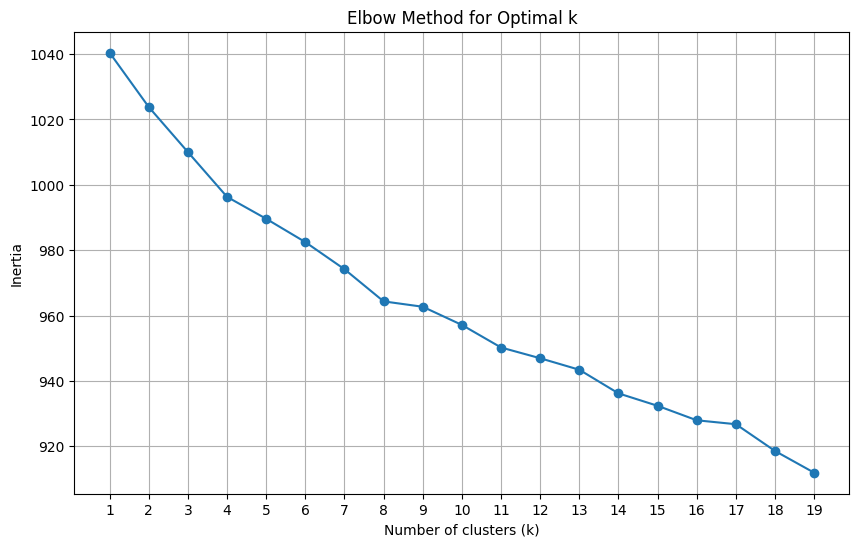

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the article titles
tfidf_matrix = tfidf_vectorizer.fit_transform(df_articles['doc_full_name'])

# Determine optimal k using the elbow method
inertia = []
k_range = range(1, 20)  # Test k from 1 to 19

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

**Reasoning**:
Implement a recommendation function that suggests the highest-scoring unseen articles for each user and compute article-article similarity from the transformed matrix (Vᵀ_r).

In [12]:
def recommend_articles_svd(user_id, k, user_item_matrix, user_item_predicted_ratings_df):
    """
    Recommends articles for a user based on predicted ratings from SVD.

    Args:
        user_id: The email address of the user.
        k: The number of recommendations to return.
        user_item_matrix: The original binary user-item matrix.
        user_item_predicted_ratings_df: The DataFrame with predicted ratings from SVD.

    Returns:
        A list of recommended article IDs.
    """
    if user_id not in user_item_predicted_ratings_df.index:
        print(f"User {user_id} not found in predicted ratings matrix. Falling back to rank-based recommendations.")
        return get_top_article_ids(k)

    # Get the predicted ratings for the user
    user_predicted_ratings = user_item_predicted_ratings_df.loc[user_id]

    # Get the articles the user has already interacted with
    interacted_articles = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 1].index.tolist()

    # Sort articles by predicted rating in descending order
    sorted_article_ratings = user_predicted_ratings.sort_values(ascending=False)

    # Get the top k articles that the user has not yet interacted with
    recommended_article_ids = [
        article_id for article_id in sorted_article_ratings.index
        if article_id not in interacted_articles
    ][:k]

    return recommended_article_ids

# Compute article-article similarity from the transformed matrix (Vt_r)
# Vt is already the transpose of V from svds, so Vt[:r, :] gives us Vt_r
article_similarity_svd = cosine_similarity(Vt[:r, :].T)

# Convert to DataFrame for easier interpretation (optional)
article_similarity_svd_df = pd.DataFrame(article_similarity_svd, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Example of getting similar articles based on SVD similarity (optional)
# Replace with a valid article ID from your data
# test_article_id_svd = 1429.0
# if test_article_id_svd in article_similarity_svd_df.index:
#     similar_articles_svd = article_similarity_svd_df.loc[test_article_id_svd].sort_values(ascending=False).index.tolist()[1:k+1]
#     print(f"\nTop {k} similar articles for article ID {test_article_id_svd} based on SVD similarity: {similar_articles_svd}")
# else:
#     print(f"\nArticle ID {test_article_id_svd} not found in SVD similarity matrix.")

# Example usage of the recommendation function (optional)
# Replace with a valid user ID from your data
# test_user_id_svd = '2b6c0f514c2f2b04ad3c4583407dccd0810469ee'
# recommended_articles_svd = recommend_articles_svd(test_user_id_svd, 10, user_item_matrix, user_item_predicted_ratings_df)
# print(f"\nTop 10 SVD recommended articles for user {test_user_id_svd}: {recommended_articles_svd}")

**Reasoning**:
Choose a latent rank (r) based on the scree plot and reconstruct the low-rank approximation of the user-item matrix.

In [11]:
# Choose the latent rank (r) based on the scree plot.
# Let's choose a value for r based on the plot where the singular values start to level off.
# For example, let's choose r = 100 (this is an example, you should choose based on your observation of the plot)
r = 100

# Reconstruct the low-rank score matrix
# We need to convert the singular values (s) into a diagonal matrix (Sigma)
Sigma = np.diag(s[:r])

# Reconstruct the matrix using the first r columns of U, the first r singular values, and the first r rows of Vt
user_item_predicted_ratings = np.dot(np.dot(U[:, :r], Sigma), Vt[:r, :])

# Convert the reconstructed matrix back to a DataFrame
user_item_predicted_ratings_df = pd.DataFrame(user_item_predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

display(user_item_predicted_ratings_df.head())

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
email,,,,,,,,,,,,,,,,,,,,,
0000b6387a0366322d7fbfc6434af145adf7fed1,0.000692,-0.000239,-0.000504,-0.000575,-0.000428,0.000116,-0.000514,-0.000314,0.000343,0.000019,...,-0.001132,-0.000379,0.000078,0.000031,-0.000064,-0.003970,0.000004,0.001674,0.000834,-0.003983
001055fc0bb67f71e8fa17002342b256a30254cd,0.000214,-0.000376,0.000123,-0.000001,0.000369,-0.000026,0.000008,0.000434,0.000232,-0.000014,...,-0.000815,-0.000248,-0.000230,0.000354,-0.000227,-0.000894,-0.001285,0.000718,0.000845,0.005696
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,-0.000327,-0.001026,-0.000636,-0.000026,0.000279,-0.000013,-0.000355,-0.000316,-0.000284,-0.000099,...,-0.002464,0.000819,-0.000088,-0.000066,-0.000496,0.009389,-0.002372,0.003016,0.002368,0.000472
001a852ecbd6cc12ab77a785efa137b2646505fe,0.000180,0.000863,-0.000764,-0.000343,-0.002055,-0.000397,-0.000252,-0.000058,0.000027,-0.000575,...,0.000269,-0.000352,-0.000134,-0.000357,-0.000212,0.003872,-0.006775,-0.000431,-0.000916,-0.001644
001fc95b90da5c3cb12c501d201a915e4f093290,0.000179,0.000583,-0.000134,-0.000088,0.000570,0.000025,-0.000349,0.000153,-0.000405,0.000144,...,0.000359,0.000011,0.000242,0.000057,-0.000590,0.000920,-0.000553,0.003628,0.000391,-0.000572


## Perform matrix factorization

### Subtask:
Apply Singular Value Decomposition (SVD) to the user-item matrix. Choose the latent rank (r) by examining the singular value scree plot or by setting an energy captured threshold. Reconstruct a low-rank score matrix. Implement a recommendation function that suggests the highest-scoring unseen articles for each user. Compute article-article similarity from the transformed matrix (Vᵀ_r).

**Reasoning**:
Apply Singular Value Decomposition (SVD) to the user-item matrix and visualize the singular values to help determine the optimal latent rank (r).

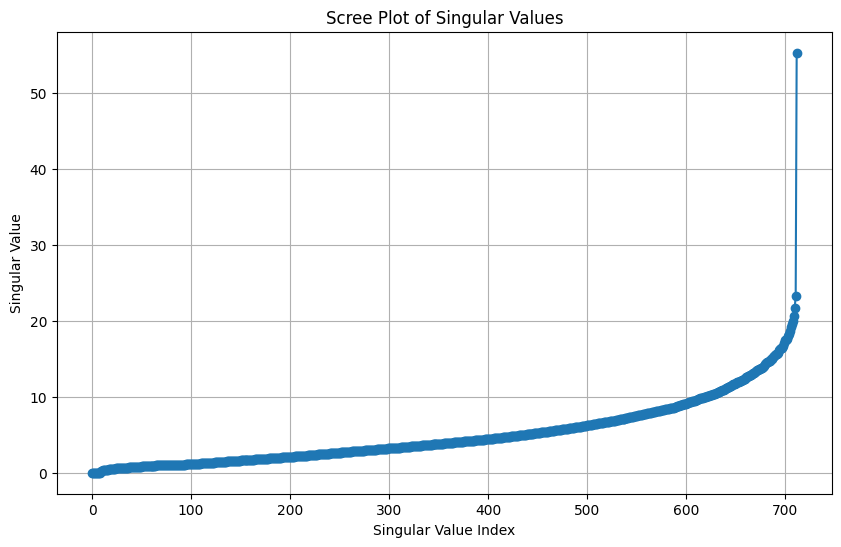

In [10]:
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

# Apply SVD to the user-item matrix
# svds returns U, sigma, Vt
# We need to convert the user_item_matrix to a NumPy array for svds
U, s, Vt = svds(user_item_matrix.values, k=min(user_item_matrix.shape)-1)

# Plot the singular values to determine the optimal number of latent factors (r)
plt.figure(figsize=(10, 6))
plt.plot(range(len(s)), s, marker='o')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Scree Plot of Singular Values')
plt.grid(True)
plt.show()

**Reasoning**:
Based on the elbow plot, a reasonable elbow appears around k=5 or k=6. Let's choose k=5. Now, fit the KMeans model with the chosen k and add the cluster labels to the articles DataFrame.



In [8]:
# Choose optimal k based on the elbow method (visually inspecting the plot)
# A potential elbow is around k=5 or k=6. Let's choose k=5 for now.
optimal_k = 5

# Initialize and fit KMeans with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)

# Add cluster labels to the articles DataFrame
df_articles['cluster_label'] = kmeans.labels_

# Display the first few rows with the new cluster label
display(df_articles.head())

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id,cluster_label
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,4
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,4
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,4
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,3


**Reasoning**:
Implement the function `get_similar_articles_content` to return top-k similar articles based on cosine similarity in the TF-IDF space, with an optional boosting mechanism for articles within the same cluster.



In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_articles_content(article_id, df_articles, tfidf_matrix, kmeans_model, k=10, boost_same_cluster=True):
  """
  Returns the top k most similar articles based on content (TF-IDF) with optional cluster boosting.

  Args:
    article_id: The ID of the article for which to find similar articles.
    df_articles: The DataFrame containing article information and cluster labels.
    tfidf_matrix: The TF-IDF matrix of article titles.
    kmeans_model: The fitted KMeans model.
    k: The number of similar articles to return.
    boost_same_cluster: Whether to boost similarity scores for articles in the same cluster.

  Returns:
    A list of the top k most similar article IDs.
  """
  # Find the index of the input article ID in the DataFrame
  article_index = df_articles[df_articles['article_id'] == article_id].index[0]

  # Calculate cosine similarity between the input article and all other articles
  cosine_sim = cosine_similarity(tfidf_matrix[article_index], tfidf_matrix).flatten()

  # Apply boosting for articles in the same cluster if enabled
  if boost_same_cluster:
    input_cluster = df_articles.loc[article_index, 'cluster_label']
    same_cluster_indices = df_articles[df_articles['cluster_label'] == input_cluster].index
    # Increase similarity for articles in the same cluster (e.g., by a small factor)
    # Avoid boosting the article itself
    for idx in same_cluster_indices:
        if idx != article_index:
            cosine_sim[idx] *= 1.2  # Boosting factor

  # Get the indices of articles sorted by similarity in descending order
  sim_indices = cosine_sim.argsort()[::-1]

  # Exclude the input article itself and get the top k indices
  top_k_indices = [i for i in sim_indices if i != article_index][:k]

  # Get the article IDs for the top k indices
  top_k_article_ids = df_articles.loc[top_k_indices, 'article_id'].tolist()

  return top_k_article_ids

# Example usage (optional, for testing)
# Replace with a valid article ID from your data
# test_article_id = 1429.0
# similar_articles = get_similar_articles_content(test_article_id, df_articles, tfidf_matrix, kmeans, k=5, boost_same_cluster=True)
# print(f"Top 5 similar articles for article ID {test_article_id}: {similar_articles}")

## Summary:

### Data Analysis Key Findings

*   The dataset contains 5148 unique users and 714 unique articles, with a total of 45,993 interactions.
*   User interaction counts range from 1 to 364, with a mean of approximately 8.93 interactions per user.
*   Article interaction counts range from 1 to 937, with a mean of approximately 64.42 interactions per article.
*   A rank-based recommendation system was implemented by sorting articles based on total interactions.
*   A binary user-item matrix was successfully created after removing duplicate user-article interactions.
*   User-user collaborative filtering functions were implemented, including a nearest neighbor search using cosine similarity and recommendation functions with popularity tie-breaking and a variant prioritizing neighbors with more common interactions.
*   A fallback mechanism to rank-based recommendations for new users was included in the collaborative filtering system.
*   TF-IDF vectorization was applied to article titles, and KMeans clustering with k=5 was used to group articles into topics based on their content.
*   A content-based recommendation function was developed using cosine similarity on TF-IDF vectors, with an optional feature to boost recommendations from the same article cluster.

### Insights or Next Steps

*   Compare the performance of the implemented recommendation systems (rank-based, user-user collaborative filtering variants, content-based) using appropriate evaluation metrics (e.g., precision, recall, or a custom metric relevant to article recommendations).
*   Implement matrix factorization methods (e.g., FunkSVD or SVD++ using libraries like Surprise) to build another recommendation system and compare its performance and characteristics with the other methods.
